This file shows the process of fitting and tuning the models. Current best model for spread predictions following the 2023 season is using the neural net alone with margins of > 3 points, for a balance of decent N and decent accuracy. This currently beats random guessing at the 2 $\sigma$ level.

In [1]:
'''
Gathers relevant CFB stats by game. Takes a long time to run the first time, but is much faster in subsequent runs.
'''


# Requires cfbd: pip install cfbd
from __future__ import print_function
import cfbd
from cfbd.rest import ApiException
from pprint import pprint
import pickle
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import FactorAnalysis
from fastai.data.transforms import RandomSplitter
from fastai.tabular.all import *
from select_features import select_features
from update_game_data import gather_game_data, gather_new_game_data, process_games

# Configure API key authorization: ApiKeyAuth
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = # Redacted
configuration.api_key_prefix['Authorization'] = 'Bearer'


games = gather_game_data(configuration)

Gathering games from  2023
Compiling games from week, year:  1 2023
Compiling games from week, year:  2 2023
Compiling games from week, year:  3 2023
Compiling games from week, year:  4 2023
Compiling games from week, year:  5 2023
Compiling games from week, year:  6 2023
Compiling games from week, year:  7 2023
Compiling games from week, year:  8 2023
Compiling games from week, year:  9 2023
Compiling games from week, year:  10 2023
Compiling games from week, year:  11 2023
Compiling games from week, year:  12 2023
Compiling games from week, year:  13 2023
Compiling games from week, year:  14 2023
Compiling games from week, year:  15 2023
Adding games to cache from  2023


In [ ]:
# Feature selection
def home_covers_spread(row):
    if row['margin'] > row['spread']:
        return 1
    else:
        return 0

games_flat = []
for year in games.keys():
    for week in games[year].keys():
        games_flat.extend([games[year][week][gid] for gid in games[year][week].keys() if ('home_elo' in games[year][week][gid].keys()) and ('away_elo' in games[year][week][gid].keys()) and games[year][week][gid]['home_elo'] is not None and games[year][week][gid]['away_elo'] is not None])

df = pd.DataFrame.from_records(games_flat).dropna()
df['covers'] = df.apply(home_covers_spread, axis=1)

df_z_scaled = df.copy().query('year > 2015 & week > 3') # Only run feature selection and engineering on complete data
excluded = ['spread','gid','year','home_team','away_team', 'home_points','margin', 'covers', 'away_points','home_wins','home_interceptions','away_interceptions','home_interceptionYards','away_interceptionYards','home_fumblesLost','away_fumblesLost','home_fumblesRecovered','away_fumblesRecovered','home_interceptions_lastSeason','away_interceptions_lastSeason','home_interceptionYards_lastSeason','away_interceptionYards_lastSeason','home_fumblesLost_lastSeason','away_fumblesLost_lastSeason','home_fumblesRecovered_lastSeason','away_fumblesRecovered_lastSeason','home_interceptions_lastThree','away_interceptions_lastThree','home_interceptionYards_lastThree','away_interceptionYards_lastThree','home_fumblesLost_lastThree','away_fumblesLost_lastThree','home_fumblesRecovered_lastThree','away_fumblesRecovered_lastThree']
# spread treated specially later to avoid losing information in various data processing methods
cat_features = ['home_conference','away_conference','neutral_site']

features = []
for column in df_z_scaled.columns:
    if column not in excluded and column not in cat_features and column != 'week':
        df_z_scaled[column] = (df_z_scaled[column] - df[column].mean())/df[column].std()
        features.append(column)
features.append('week')
     
# Needs df with only included features

df_features_scaled = df_z_scaled.filter(features, axis=1)


df_fa  = df_features_scaled.copy()

for column in cat_features:
    df_fa[column] = df_z_scaled[column]
    
for column in excluded:
    if column in df_z_scaled.columns:
        df_fa[column] = df_z_scaled[column]

selected_features = list(select_features(df, df_fa, excluded=excluded, cat_features=cat_features,threshold = 0.8))

selected_cont_features = [feature for feature in selected_features if feature not in excluded and feature not in cat_features]
    
    


In [3]:
# Lasso method

df_fa['spread'] = (df['spread'] - df['spread'].mean())/df['spread'].std()

df_fa.head()
        
train_df = df_fa.query("2015 < year < 2023")
cont_features = [c for c in df_fa.columns if c not in cat_features and c not in excluded[0:] and c in selected_features] #Spread out 
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names="margin",
                    cat_names = cat_features,
                    cont_names = cont_features,
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
lasso_cv = LassoCV(cv=5,max_iter=int(1e6)).fit(X_train, y_train)
sfm = SelectFromModel(lasso_cv, prefit=True) 
selected_feature_indices = np.where(sfm.get_support())[0] 
selected_features_2 = list(X_train.columns[selected_feature_indices])
coefficients = lasso_cv.coef_ 
print("N Selected Features:", len(selected_features_2))
print("Feature Coefficients:", coefficients) 
excluded_2 = [cont_features[i] for i in range(len(cont_features)) if cont_features[i] not in selected_features_2]


N Selected Features: 46
Feature Coefficients: [ 0.          0.          0.         -8.606428    7.181197   -0.
 -0.08898515 -0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.
  0.         -0.53192276  0.72248083  0.         -0.         -0.20087047
 -0.          0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.         -0.
 -0.          0.          0.13000391  0.07124181 -0.          0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.0999706  -0.         -0.         -0.         -0.          0.
  0.         -0.          0.40716684 -0.         -0.         -0.
 -0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.         -0.          0.
  0.05206358 -0.          0.         -0.          0.          0.
 -0.         -0.          0.          0.          0.          0.
  0.         -0.07211427  0.        

In [5]:
# Neural net tuning

def fit_with(lr:float, wd:float, dp:float, n_layers:float, layer_1:float, layer_2:float, layer_3:float,num_steps:float):

    print(lr, wd, dp)
    if int(n_layers) == 2:
        layers = [int(layer_1), int(layer_2)]
    elif int(n_layers) == 3:
        layers = [int(layer_1), int(layer_2), int(layer_3)]
    else:
        layers = [int(layer_1)]
    config = tabular_config(embed_p=float(dp),ps=float(wd))
    learn = tabular_learner(dls, layers=layers, metrics=mae, config = config)
  
    with learn.no_bar() and learn.no_logging():
        learn.fit(int(num_steps), lr=float(lr))
        
    acc = float(learn.validate()[1])
    
    return -1.*acc


train_df, val_df = train_test_split(df_fa, test_size=0.2)

excluded = ['gid','year','home_team','away_team', 'home_points','margin', 'covers', 'away_points','home_wins']#,'spread'
cat_features = ['home_conference','away_conference','neutral_site']
cont_features = [c for c in selected_features_2 if c not in cat_features and c not in excluded]




print(train_df[cont_features])
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names="margin",
                    cat_names = cat_features,
                    cont_names = cont_features,
                    splits=splits)
dls = to.dataloaders(bs=64)
dls.show_batch()

# tune_model(train_df[cont_features],train_df['spread'])

learn = tabular_learner(dls, metrics=mae)
hps = {'lr': (1e-05, 1e-01),
      'wd': (4e-4, 0.5),
      'dp': (0.01, 0.5),
       'n_layers': (1,3),
       'layer_1': (5, 200),
       'layer_2': (5, 100),
       'layer_3': (1, 200),
      'num_steps': (5,50)}
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = hps, # our hyper parameters to tune
    verbose = 2, # 1 prints out when a maximum is observed, 0 for silent
    random_state=1
)

optim.maximize(n_iter=10)

print(optim.max)

      home_elo  away_elo  home_rushingTDs  home_passesIntercepted  \
6622  0.530506  0.571797        -0.660581                0.746001   
3506 -0.061634 -0.262768        -0.462485                1.355397   
7805 -0.503655  2.647828         0.149811                0.709067   
4082 -0.161714  1.040980         1.178880               -0.530831   
6739  0.301156  1.057588         1.037383               -0.530831   
...        ...       ...              ...                     ...   
4560  1.660576  0.148286         2.971176                1.693951   
5518  1.794016 -1.001835         1.320377               -0.563074   
4685  1.360336  0.073549        -0.066293                1.152265   
4589 -0.182564  0.467995         0.825138                0.339736   
4032 -1.074945 -1.363065        -0.825661                0.001182   

      home_thirdDowns  home_defense_plays_perDrive  \
6622        -0.027161                     0.062037   
3506         0.208589                     0.623811   
7805     

,home_conference,away_conference,neutral_site,home_elo,away_elo,home_rushingTDs,home_passesIntercepted,home_thirdDowns,home_defense_plays_perDrive,home_defense_rushingPlays_rate,home_defense_rushingPlays_totalPPA_perDrive,home_offense_lineYards,home_offense_passingDowns_rate,away_tacklesForLoss,away_defense_powerSuccess,away_defense_openFieldYardsTotal,away_defense_passingDowns_successRate,away_defense_passingDowns_explosiveness,away_defense_rushingPlays_successRate,away_offense_totalOpportunies_perDrive,away_offense_havoc_db,home_thirdDowns_lastSeason,home_defense_havoc_total_lastSeason,home_offense_havoc_total_lastSeason,home_offense_passingPlays_explosiveness_lastSeason,away_puntReturnTDs_lastSeason,away_sacks_lastSeason,away_defense_powerSuccess_lastSeason,away_defense_passingPlays_explosiveness_lastSeason,away_offense_passingPlays_explosiveness_lastSeason,home_puntReturnTDs_lastThree,home_sacks_lastThree,home_kickReturns_lastThree,home_defense_stuffRate_lastThree,home_defense_havoc_total_lastThree,home_defense_rushingPlays_rate_lastThree,home_defense_passingPlays_explosiveness_lastThree,home_offense_stuffRate_lastThree,home_offense_havoc_db_lastThree,home_offense_passingDowns_rate_lastThree,home_offense_passingDowns_explosiveness_lastThree,away_rushingTDs_lastThree,away_firstDowns_lastThree,away_passesIntercepted_lastThree,away_netPassingYards_lastThree,away_defense_havoc_total_lastThree,away_defense_rushingPlays_explosiveness_lastThree,away_offense_havoc_total_lastThree,away_offense_passingDowns_successRate_lastThree,margin
0,SEC,SEC,False,0.134356,0.301912,0.990218,0.339736,-0.212904,1.187086,0.696778,1.645455,0.821365,0.387575,-0.206834,0.020286,-0.085048,0.543602,0.518108,0.385039,0.276382,-0.681155,-0.207790,-0.183241,-0.044372,-0.113988,-0.612874,1.056469,0.139472,0.267296,0.007035,-0.279685,0.610020,-0.519294,-0.720319,-0.140555,0.513451,0.265956,-0.394360,-0.174530,0.160745,0.507479,0.635054,0.652482,-0.350008,0.565293,0.162162,-0.326526,-0.002717,0.157900,10.0
1,Conference USA,Conference USA,False,-0.486975,-0.316745,-0.858677,-0.879057,0.101430,0.373668,0.012451,0.422581,-0.261240,0.498613,1.101084,0.394275,1.952214,0.641506,-0.117285,-0.011638,0.860203,0.787897,-0.522558,-0.434971,1.132982,-0.000240,0.746265,0.732553,-0.124124,0.249358,-0.090649,-0.279685,0.268671,1.092518,-0.491438,2.227462,0.188199,1.222775,0.922285,1.042075,0.603601,1.176146,0.344360,0.500542,0.173846,0.755233,-0.023131,1.858008,0.946714,1.045032,-18.0
2,SEC,SEC,False,-0.182564,0.467995,0.825138,0.339736,0.251452,0.541004,0.217899,-1.003736,0.720286,0.192293,-0.176836,-0.068185,0.670711,1.773876,0.322584,0.285442,0.409564,2.996413,-0.436083,-0.679742,-0.409034,0.748873,0.746265,0.624581,-0.625109,0.005714,-0.500209,-0.279685,0.382454,0.224619,0.711390,0.693578,-0.078723,0.341954,-0.046572,0.245028,-0.019102,-0.195323,0.053667,0.739305,0.697699,0.307636,0.108276,0.994165,1.633209,0.490854,-17.0
3,Sun Belt,Sun Belt,False,-1.437735,-1.026748,-0.363437,-0.269661,0.165725,0.607353,0.582779,0.753096,0.148233,0.653565,0.363130,-0.364884,1.163596,0.708793,0.845034,-0.088656,-0.062675,0.762052,0.134650,0.182975,2.821020,0.087455,-0.612874,0.516609,0.388084,-0.403438,0.655792,-0.279685,-0.755377,2.456359,-0.773943,-0.828678,1.338291,-0.114998,0.698621,1.587554,0.809607,0.791146,-0.963760,0.500542,-0.611935,0.378657,-0.371182,0.006030,0.146445,-0.062673,-2.0
4,FBS Independents,Mid-American,False,-2.117445,-1.844704,-0.165341,0.339736,0.680089,0.309164,0.993630,2.538031,0.140805,0.506521,0.093147,-0.051171,-0.468404,0.959062,0.030898,0.480750,-0.593330,0.108255,-0.359986,-0.890121,0.849917,0.309840,0.746265,-0.455138,0.011143,-0.468695,0.392609,2.203246,-0.527811,3.448243,-0.602166,-0.384324,1.075523,0.239816,0.345023,2.276611,0.507206,1.051903,-1.109107,-0.606450,-0.350008,0.720549,0.301773,-0.069940,1.142859,-0.365874,-8.0
5,American Athletic,American Athletic,False,-0.632925,-0.922946,-0.330421,-0.337371,0.430051,0.254728,0.185536,-0.182170,0.365842,

|   iter    |  target   |    dp     |  layer_1  |  layer_2  |  layer_3  |    lr     | n_layers  | num_steps |    wd     |
-------------------------------------------------------------------------------------------------------------------------
0.014684121522803134 0.17304213923070666 0.21434078230426126


| 1         | -13.77    | 0.2143    | 145.5     | 5.011     | 61.16     | 0.01468   | 1.185     | 13.38     | 0.173     |
0.02045318045065443 0.33536556808512974 0.20441606237302828


| 2         | -12.94    | 0.2044    | 110.1     | 44.82     | 137.4     | 0.02045   | 2.756     | 6.232     | 0.3354    |
0.08007644942186691 0.3462843787883893 0.21447935315989222


| 3         | -13.51    | 0.2145    | 113.9     | 18.34     | 40.42     | 0.08008   | 2.937     | 19.1      | 0.3463    |
0.016991343652261244 0.21078536945252407 0.4394306846250588


| 4         | -14.32    | 0.4394    | 179.4     | 13.08     | 8.772     | 0.01699   | 2.756     | 9.426     | 0.2108    |
0.06865322775888155 0.3751720997465057 0.47936586977374596


| 5         | -13.25    | 0.4794    | 109.0     | 70.73     | 63.79     | 0.06865   | 2.669     | 5.823     | 0.3752    |
0.06080083260120823 0.26988485659395833 0.05261671374575717


| 6         | -13.88    | 0.05262   | 115.8     | 20.74     | 38.24     | 0.0608    | 2.939     | 20.34     | 0.2699    |
0.09592249717907744 0.4738135450568632 0.4046676045690938


| 7         | -12.83    | 0.4047    | 34.6      | 35.76     | 87.01     | 0.09592   | 2.295     | 29.48     | 0.4738    |
0.043225948784827176 0.17433769680391295 0.12259474557375995


| 8         | -13.49    | 0.1226    | 36.78     | 37.18     | 86.78     | 0.04323   | 1.565     | 22.92     | 0.1743    |
0.052497599396211105 0.08366095636784318 0.2631460218820466


| 9         | -14.87    | 0.2631    | 32.69     | 35.82     | 83.81     | 0.0525    | 1.469     | 33.39     | 0.08366   |
0.08026604259231103 0.3004227655534269 0.07302823789258306


| 10        | -13.21    | 0.07303   | 9.062     | 89.29     | 160.1     | 0.08027   | 1.943     | 42.18     | 0.3004    |
0.05913093540465243 0.4402460598070787 0.4776852616612355


| 11        | -13.42    | 0.4777    | 104.1     | 36.29     | 108.0     | 0.05913   | 2.105     | 33.61     | 0.4402    |
0.051429092321335364 0.09935005663953349 0.054676850361958164


| 12        | -15.45    | 0.05468   | 95.9      | 14.53     | 141.5     | 0.05143   | 1.974     | 49.19     | 0.09935   |
0.022854948489175717 0.4748805523148369 0.05040457871692479


| 13        | -13.36    | 0.0504    | 53.66     | 26.08     | 174.1     | 0.02285   | 1.831     | 22.1      | 0.4749    |
0.019840803952430968 0.3109786567565107 0.12842374279973842


| 14        | -15.03    | 0.1284    | 168.8     | 85.92     | 117.9     | 0.01984   | 1.222     | 37.41     | 0.311     |
0.07226581500164518 0.38192625361866056 0.15912879684598275


| 15        | -13.0     | 0.1591    | 103.3     | 5.237     | 168.6     | 0.07227   | 1.463     | 6.85      | 0.3819    |
{'target': -12.832524299621582, 'params': {'dp': 0.4046676045690938, 'layer_1': 34.598475585257546, 'layer_2': 35.75511910908871, 'layer_3': 87.00712173218196, 'lr': 0.09592249717907744, 'n_layers': 2.2948039076327684, 'num_steps': 29.479302065479875, 'wd': 0.4738135450568632}}


epoch,train_loss,valid_loss,mse,time
0,323.420074,272.131348,272.131348,00:00
1,294.127350,278.748657,278.748657,00:00
2,280.409119,269.909973,269.909973,00:00
3,271.700806,264.311157,264.311157,00:00


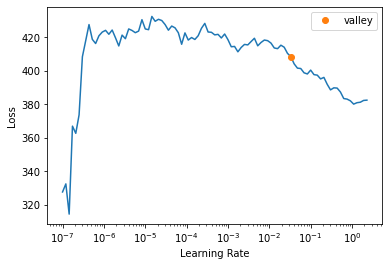

In [10]:
# Initial fit of neural net
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names="margin",
                    cat_names = cat_features,
                    cont_names = cont_features,
                    splits=splits)
dls = to.dataloaders(bs=64)
layers = [35,35]
config = tabular_config(embed_p=0.4,
                      ps=0.47)
learn = tabular_learner(dls, layers=layers, metrics=mse, config = config)
learn.lr_find()
learn.fit(4,lr=0.05)

In [11]:
# Manual fitting of neural net
learn.fit(1,lr=0.01)

epoch,train_loss,valid_loss,mse,time
0,257.316010,265.301483,265.301483,00:00


In [12]:
# Neural net validation

pdf_net = val_df.copy()
# pdf['spread'] = (pdf['spread'] - df['spread'].mean()) / df['spread'].std()
dl_net = learn.dls.test_dl(pdf_net)
pdf_net['predicted'] = learn.get_preds(dl=dl_net)[0].numpy()
pdf_net['real_spread']=pdf_net['spread'] * df['spread'].std() + df['spread'].mean()
pdf_net['real_margin'] = pdf_net['margin']
pdf_net['real_predicted'] = pdf_net['predicted']

print('Analysis of neural net performance, by difference from spread')

for margin in range(10):
    count = 0
    countTrue = 0
    for i in pdf_net.index:
        prediction_net_minus_spread = pdf_net['real_predicted'][i] - pdf_net['real_spread'][i]

        if prediction_net_minus_spread < -margin:
            prediction = -1
        elif prediction_net_minus_spread > margin:
            prediction = 1
        else:
            continue
        if prediction == (abs(pdf_net['real_margin'][i]-pdf_net['real_spread'][i])/(pdf_net['real_margin'][i]- pdf_net['real_spread'][i])):
            countTrue += 1
        count += 1
    print(margin, count, countTrue/count)

Analysis of neural net performance, by difference from spread
0 471 0.5074309978768577
1 398 0.535175879396985
2 327 0.5412844036697247
3 260 0.5615384615384615
4 207 0.5555555555555556
5 175 0.5485714285714286
6 136 0.5441176470588235
7 106 0.5566037735849056
8 80 0.5875
9 57 0.6140350877192983


C:\Users\willi\AppData\Local\Temp/ipykernel_19396/1898021362.py:25: RuntimeWarning: invalid value encountered in scalar divide
  if prediction == (abs(pdf_net['real_margin'][i]-pdf_net['real_spread'][i])/(pdf_net['real_margin'][i]- pdf_net['real_spread'][i])):


In [ ]:
excluded = ['gid', 'year', 'home_team', 'away_team', 'home_points', 'margin', 'covers', 'away_points', 'home_wins']
cat_features = ['home_conference', 'away_conference', 'neutral_site']
cont_features = [c for c in selected_features_2 if c not in cat_features and c not in excluded]

monotonicity = []
for feature in cont_features:
    corr = train_df[feature].corr(train_df['covers'])
    if corr < -.4:
        monotonicity.append(-1)
    elif corr > .4:
        monotonicity.append(1)
    else:
        monotonicity.append(0)
monotonicity = tuple(monotonicity)

folds = 5

param_grid = {
    'learning_rate': [0.01, 0.05, 0.10, 0.20],  
    'min_child_weight': [1, 5, 10],  
    'gamma': [0.5, 1, 5],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'max_depth': [2, 3, 4],
    'reg_lambda': [0.5, 1, 1.5, 2],
    'reg_alpha': [0, 0.5, 1]
}

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=11)

grid = RandomizedSearchCV(
    XGBClassifier(
        objective='binary:logistic', 
        monotone_constraints=monotonicity, 
        use_label_encoder=False
    ), 
    param_grid,
    n_jobs=1,
    cv=skf.split(train_df[cont_features], train_df['covers']),
    scoring='accuracy',
    verbose=3,
    refit=True,
    n_iter=100
)

grid.fit(train_df[cont_features], train_df['covers'], early_stopping_rounds=10, eval_metric="logloss", eval_set=[(train_df[cont_features], train_df['covers'])], verbose=True)

pdf = val_df.copy()
pdf['predicted'] = grid.predict(val_df[cont_features])
pdf['real_spread'] = pdf['spread'] * df['spread'].std() + df['spread'].mean()
pdf['real_margin'] = pdf['margin']
pdf['predicted_prob'] = grid.predict_proba(val_df[cont_features])[:, 1]

count = 0
countTrue = 0

for i in pdf.index:
    if (abs(pdf['predicted_prob'][i] - .5) / (pdf['predicted_prob'][i] - .5)) == (abs(pdf['real_margin'][i] - pdf['real_spread'][i]) / (pdf['real_margin'][i] - pdf['real_spread'][i])):
        countTrue += 1
    count += 1

print('Game accuracy: ', countTrue / count)

In [15]:
grid.best_params_

{'subsample': 0.6,
 'reg_lambda': 1.5,
 'reg_alpha': 0,
 'min_child_weight': 10,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 1.0}

In [18]:
df_to_use = val_df
pdf = df_to_use.copy()
pdf['predicted'] = grid.predict(df_to_use[cont_features])
pdf['real_spread']=pdf['spread'] * df['spread'].std() + df['spread'].mean()
pdf['real_margin'] = pdf['margin']
pdf['predicted_prob'] = grid.predict_proba(df_to_use[cont_features])[:, 1]
count = 0
countTrue = 0

for i in pdf.index:
    
    if (abs(pdf['predicted_prob'][i]-.5)/(pdf['predicted_prob'][i]-.5)) == (abs(pdf['real_margin'][i]-pdf['real_spread'][i])/(pdf['real_margin'][i]-pdf['real_spread'][i])):
        countTrue += 1
    count += 1
print('Game accuracy: ', countTrue/count)

Game accuracy:  0.47558386411889597


C:\Users\willi\AppData\Local\Temp/ipykernel_19396/765495859.py:12: RuntimeWarning: invalid value encountered in scalar divide
  if (abs(pdf['predicted_prob'][i]-.5)/(pdf['predicted_prob'][i]-.5)) == (abs(pdf['real_margin'][i]-pdf['real_spread'][i])/(pdf['real_margin'][i]-pdf['real_spread'][i])):


In [20]:
print('Analysis of XGBoost performance, by confidence')
for margin in np.arange(0.5,0.8,.05):
    count = 0
    countTrue = 0
    for i in pdf.index:
        prob_xgboost = pdf['predicted_prob'][i]
        result = abs(pdf['real_margin'][i]-pdf['real_spread'][i])/(pdf['real_margin'][i]- pdf['real_spread'][i]) # 1 if home covers else -1
        if prob_xgboost > margin and result > 0:
            countTrue += 1
        elif prob_xgboost < 1 - margin and result < 0:
            countTrue += 1
        if (prob_xgboost > margin or prob_xgboost < 1-margin) and result is not None:
            count += 1
    print(margin, count, countTrue/count)

Analysis of XGBoost performance, by confidence
0.5 471 0.47558386411889597
0.55 296 0.5067567567567568
0.6000000000000001 153 0.5424836601307189
0.6500000000000001 64 0.546875
0.7000000000000002 25 0.56
0.7500000000000002 9 0.4444444444444444
0.8000000000000003 1 0.0


C:\Users\willi\AppData\Local\Temp/ipykernel_19396/3926772144.py:7: RuntimeWarning: invalid value encountered in scalar divide
  result = abs(pdf['real_margin'][i]-pdf['real_spread'][i])/(pdf['real_margin'][i]- pdf['real_spread'][i]) # 1 if home covers else -1


In [154]:
print('Analysis of XGBoost performance, by confidence')
for margin in np.arange(0.5,0.95,.05):
    count = 0
    countTrue = 0
    for i in pdf.index:
        prob_xgboost = pdf['predicted_prob'][i]
        result = pdf['covers'][i] # 1 if home covers else -1
        if ((prob_xgboost > margin) or (prob_xgboost < 1-margin)) and round(prob_xgboost) == round(result):
            countTrue += 1
        if (prob_xgboost > margin or prob_xgboost < 1-margin):
            count += 1
    print(margin, count, countTrue/count)

Analysis of XGBoost performance, by confidence
0.5 471 0.5074309978768577
0.55 391 0.5012787723785166
0.6000000000000001 323 0.4984520123839009
0.6500000000000001 255 0.5019607843137255
0.7000000000000002 187 0.5026737967914439
0.7500000000000002 131 0.549618320610687
0.8000000000000003 80 0.575
0.8500000000000003 43 0.5581395348837209
0.9000000000000004 16 0.5


In [29]:
print('Analysis of performance, by difference from spread')

for margin in range(10):
    count = 0
    countTrue = 0
    for i in pdf_net.index:
        prediction_net_minus_spread = pdf_net['real_predicted'][i] - pdf_net['real_spread'][i]
        prediction_xgboost_minus_spread = pdf['predicted_prob'][i]
        
        if prediction_net_minus_spread < -margin and prediction_xgboost_minus_spread < .45:
            prediction = -1
        elif prediction_net_minus_spread > margin and prediction_xgboost_minus_spread > .55:
            prediction = 1
        else:
            continue
        if prediction == (abs(pdf_net['real_margin'][i]-pdf_net['real_spread'][i])/(pdf_net['real_margin'][i]- pdf_net['real_spread'][i])):
            countTrue += 1
        count += 1
    print(margin, count, countTrue/count)

Analysis of performance, by difference from spread
0 185 0.5243243243243243
1 163 0.5460122699386503
2 133 0.5488721804511278
3 107 0.5700934579439252
4 85 0.5882352941176471
5 73 0.5753424657534246
6 57 0.5964912280701754
7 44 0.6136363636363636
8 35 0.6857142857142857
9 24 0.7083333333333334


C:\Users\willi\AppData\Local\Temp/ipykernel_19396/1399544296.py:16: RuntimeWarning: invalid value encountered in scalar divide
  if prediction == (abs(pdf_net['real_margin'][i]-pdf_net['real_spread'][i])/(pdf_net['real_margin'][i]- pdf_net['real_spread'][i])):


In [32]:
with open("features_for_cfb_model.dat",'wb') as f:
    pickle.dump(selected_features_2, f) 
    
with open("neural_net_for_spread_cfb.dat",'wb') as f:
    pickle.dump(learn, f)
    
with open("XGBoost_for_spread_cfb.dat",'wb') as f:
    pickle.dump(grid.best_estimator_, f)